<a href="https://colab.research.google.com/github/mustafizz007/ML/blob/main/MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TASK 1**

uploaded dataset from drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile

# Verify the path to your zip file
zip_path = '/content/drive/My Drive/ML_project/archive.zip'
extract_path = '/content/brain_tumor_dataset'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)



Mounted at /content/drive


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

 The state of files inside extract_path

In [ ]:
# prompt: want to see the state of files inside extract_path
import os
print(os.listdir(extract_path))



['Training', 'Testing']


One Image per Class (from Training)

Tumor types: ['notumor', 'pituitary', 'meningioma', 'glioma']


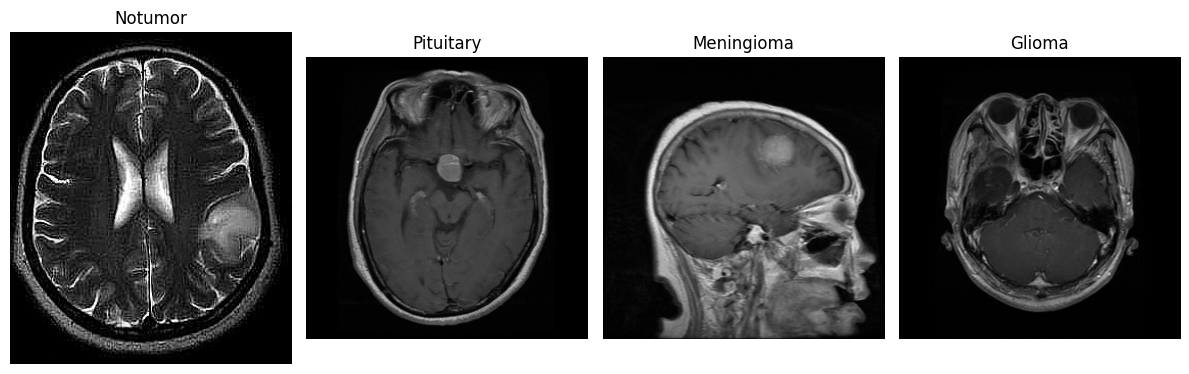

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Path to the training set
train_path = os.path.join(extract_path, 'Training')

# List of classes
classes = os.listdir(train_path)
print("Tumor types:", classes)

# Plot one sample image per class
plt.figure(figsize=(12, 4))

for i, tumor_class in enumerate(classes):
    class_path = os.path.join(train_path, tumor_class)
    img_files = os.listdir(class_path)

    # Find first valid image file
    for img_file in img_files:
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(class_path, img_file)
            break

    # Load image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(1, len(classes), i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(tumor_class.capitalize())
    plt.axis('off')

plt.tight_layout()
plt.show()


1. Extract features

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np # Import numpy

# function for extracting features
def extract_features(img):
    # Resize image to fixed size
    img = cv2.resize(img, (128, 128))

    # Statistical features
    mean = np.mean(img)
    std = np.std(img)
    var = np.var(img)

    # Histogram (32 bins for pixel intensity)
    hist = cv2.calcHist([img], [0], None, [32], [0, 256]).flatten()

    # Combine features into one array
    features = [mean, std, var] + list(hist)
    #return features
    return [mean, std, var] + list(hist)




In [ ]:
import pandas as pd
train_path = '/content/brain_tumor_dataset/Training'
X_train = []
y_train = []

for label in os.listdir(train_path):
    class_path = os.path.join(train_path, label)
    for img_name in os.listdir(class_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            features = extract_features(img)
            X_train.append(features)
            y_train.append(label)


test_path = '/content/brain_tumor_dataset/Testing'
X_test = []
y_test = []

for label in os.listdir(test_path):
    class_path = os.path.join(test_path, label)
    for img_name in os.listdir(class_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            features = extract_features(img)
            X_test.append(features)
            y_test.append(label)


df = pd.DataFrame(X_train)
df['label'] = y_train


In [ ]:
print("Image count per class:")
print(df['label'].value_counts())

#print("\nDescriptive statistics of features:")
#print(df.drop('label', axis=1).describe())


Image count per class:
label
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64


Raw Features used in RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier # Import the RandomForestClassifier class

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix # Import classification_report and confusion_matrix
y_pred = model.predict(X_test)


print("Accuracy with Raw Features and RF:", model.score(X_test, y_test))

#print("Classification Report:")
#print(classification_report(y_test, y_pred))




Accuracy with Raw Features and RF: 0.9221967963386728


Confusion mat (Raw Features)

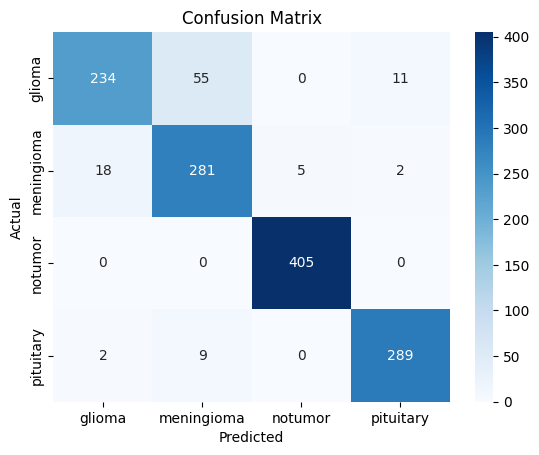

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


In [ ]:
svm_model = make_pipeline(
    StandardScaler(),       # scales all features to mean=0, std=1
    SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)  # RBF = non-linear kernel
)

svm_model.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=42))])

SVM Accuracy: 0.7635392829900839


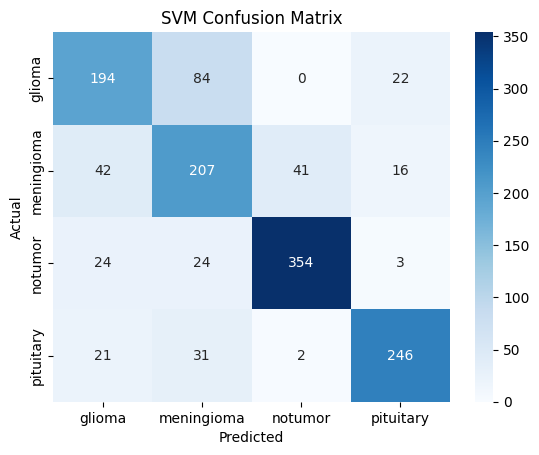

In [ ]:
y_pred_svm = svm_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report
#print("SVM Classification Report:")
#print(classification_report(y_test, y_pred_svm))

accuracy = svm_model.score(X_test, y_test)
print("SVM Accuracy:", accuracy)


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()


Doing PCA


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Apply PCA
pca = PCA(n_components=10)  # reduce to 10 components
X_pca = pca.fit_transform(X_scaled)

# See how much variance each component explains
print("Explained variance per component:", pca.explained_variance_ratio_)
print("Total variance retained:", sum(pca.explained_variance_ratio_))


Explained variance per component: [0.41287317 0.12288619 0.08288451 0.06923011 0.05849692 0.03910398
 0.0301251  0.02629663 0.02438083 0.02216314]
Total variance retained: 0.888440569936858


 Visualizing with PCA

<ipython-input-17-8b406f126442>:5: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  plt.scatter(X_2d[:, 0], X_2d[:, 1], c=pd.factorize(y_train)[0], cmap='viridis')


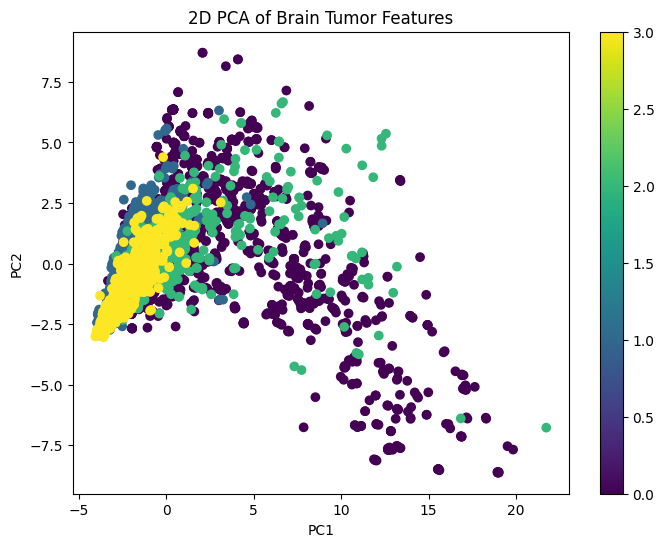

In [ ]:
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=pd.factorize(y_train)[0], cmap='viridis')
plt.title("2D PCA of Brain Tumor Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()


Random Forest + PCA (10 comp)



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scale your feature set (important before PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=10)  # You can experiment with 5, 10, 15, etc.
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# How much variance is retained?
print("Total variance retained:", sum(pca.explained_variance_ratio_))


Total variance retained: 0.888440569936858


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pca.fit(X_train_pca, y_train)


RandomForestClassifier(random_state=42)

Accuracy with RF + PCA: 0.9084668192219679


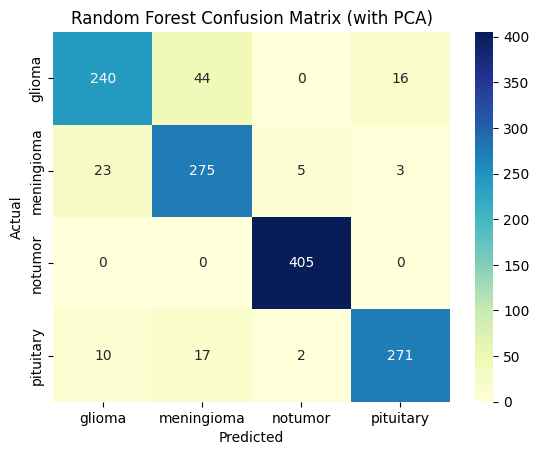

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_pca = rf_pca.predict(X_test_pca)

print("Accuracy with RF + PCA:", accuracy_score(y_test, y_pred_pca))
#print("\nClassification Report with PCA:")
#print(classification_report(y_test, y_pred_pca))

# Confusion Matrix
cm_pca = confusion_matrix(y_test, y_pred_pca)
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=rf_pca.classes_,
            yticklabels=rf_pca.classes_)
plt.title("Random Forest Confusion Matrix (with PCA)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Feature Selection + PCA + RF



In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Step 1: Train RF on all features to get importance
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_train, y_train)

# Get feature importances
importances = rf_temp.feature_importances_
indices = np.argsort(importances)[::-1]  # descending order

# Select top 20 features
top_n = 20
top_indices = indices[:top_n]

# Convert X_train and X_test to NumPy arrays
X_train = np.array(X_train)  # Convert X_train to a NumPy array
X_test = np.array(X_test)  # Convert X_test to a NumPy array

# Filter X_train and X_test using selected features
X_train_selected = X_train[:, top_indices]
X_test_selected = X_test[:, top_indices]

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Apply PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Variance retained
print("Variance retained by PCA:", sum(pca.explained_variance_ratio_))


Variance retained by PCA: 0.9541003413075979


In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)


RandomForestClassifier(random_state=42)

Accuracy (Feature Selection + PCA + RF): 0.8909229595728452


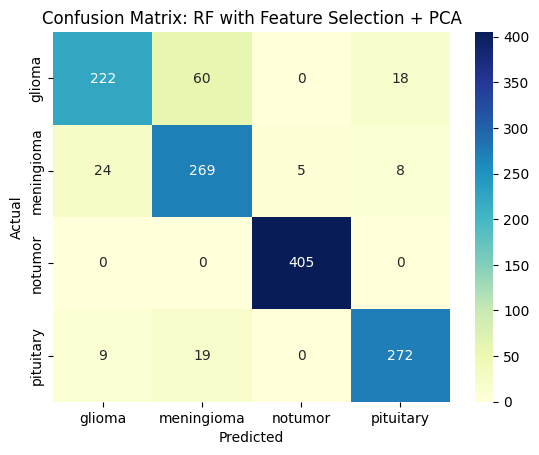

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = rf_model.predict(X_test_pca)

print("Accuracy (Feature Selection + PCA + RF):", accuracy_score(y_test, y_pred))


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title("Confusion Matrix: RF with Feature Selection + PCA")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


CV + Feature Selection + PCA + RF

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel

# Step 1: Select top 20 features based on RF
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42),
                                   max_features=20, threshold=-np.inf)

# Step 2: Define the full pipeline
pipeline = Pipeline([
    ('feature_selection', feature_selector),
    ('scaling', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [ ]:
from sklearn.model_selection import cross_val_score

# 5-fold stratified cross-validation
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-Validation Scores:", scores)
print("Average Accuracy:", scores.mean())


Cross-Validation Scores: [0.86176728 0.86176728 0.88091068 0.8642732  0.86339755]
Average Accuracy: 0.866423198851457


**TASK 2**

Exploratory Data Analysis (EDA)

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set the dataset path
train_path = '/content/brain_tumor_dataset/Training'

# Initialize class info
class_counts = {}
image_shapes = []
color_channels = defaultdict(int)
sample_images = {}

# Loop through each class folder
for class_name in os.listdir(train_path):
    class_folder = os.path.join(train_path, class_name)
    image_files = [f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg', '.png'))]

    # Store class count
    class_counts[class_name] = len(image_files)

    # Store one sample image from each class
    sample_images[class_name] = os.path.join(class_folder, image_files[0])

    # Analyze a few images to check dimensions and color channels
    for img_file in image_files[:5]:  # check 5 images per class
        img_path = os.path.join(class_folder, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            image_shapes.append(img.shape)
            if len(img.shape) == 2 or img.shape[2] == 1:
                color_channels['Grayscale'] += 1
            else:
                color_channels['RGB'] += 1

In [ ]:
# Show dataset structure summary
unique_shapes = set(image_shapes)
print(f"\nUnique Image Dimensions Found: {unique_shapes}")
print(f"Color Channel Types: {dict(color_channels)}")


Unique Image Dimensions Found: {(326, 276, 3), (512, 512, 3), (245, 206, 3), (417, 428, 3), (340, 339, 3), (630, 630, 3), (198, 150, 3)}
Color Channel Types: {'RGB': 20}


Sample Images from Each Class:


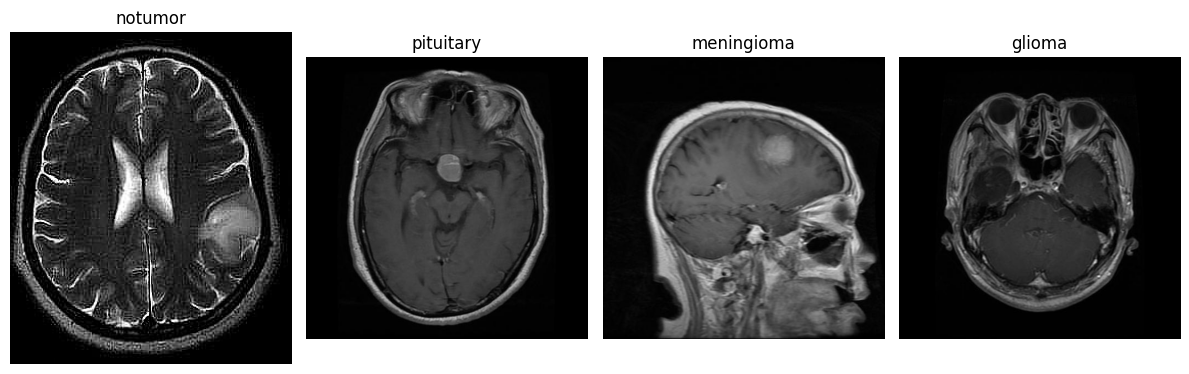

In [ ]:
# Plot sample images with labels
print("Sample Images from Each Class:")
plt.figure(figsize=(12, 6))
for i, (label, img_path) in enumerate(sample_images.items()):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(sample_images), i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

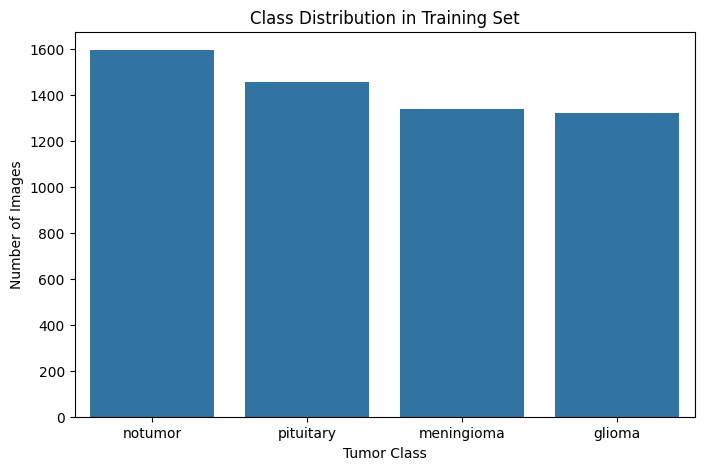

In [ ]:
# Plot bar chart of class distribution
plt.figure(figsize=(8,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.xlabel("Tumor Class")
plt.show()

In [ ]:
# Print class imbalance summary
print("\nImage Count per Class:")
for cls, count in class_counts.items():
    print(f"- {cls}: {count} images")


Image Count per Class:
- notumor: 1595 images
- pituitary: 1457 images
- meningioma: 1339 images
- glioma: 1321 images


In [ ]:
# Detect potential imbalance
min_class = min(class_counts, key=class_counts.get)
max_class = max(class_counts, key=class_counts.get)
print(f"\nPotential imbalance detected between '{max_class}' ({class_counts[max_class]} images) and '{min_class}' ({class_counts[min_class]} images).")


Potential imbalance detected between 'notumor' (1595 images) and 'glioma' (1321 images).


**TASK 3**

Data Processing

In [ ]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define parameters
image_size = (128, 128)
data_path = '/content/brain_tumor_dataset/Training'
augmented_images = []
augmented_labels = []

#X = np.array(X)
#y = np.array(y)

mean & std function

In [ ]:
# Mean and std (you can also compute this from EDA phase)
def calculate_mean_std(images):
    all_pixels = np.concatenate([img.flatten() for img in images])
    return np.mean(all_pixels), np.std(all_pixels)

augmentation function

In [ ]:
# Define augmentation functions
def apply_augmentations(image):
    aug_images = []

    # Original
    aug_images.append(image)

    # Flipping
    aug_images.append(cv2.flip(image, 1))  # horizontal
    aug_images.append(cv2.flip(image, 0))  # vertical

    # Rotation
    angle = random.choice([15, -15, 30])
    M = cv2.getRotationMatrix2D((image.shape[1]//2, image.shape[0]//2), angle, 1)
    aug_images.append(cv2.warpAffine(image, M, (image.shape[1], image.shape[0])))

    # Brightness
    bright = cv2.convertScaleAbs(image, alpha=1.1, beta=30)
    aug_images.append(bright)

    # Cropping (center crop)
    crop = image[16:112, 16:112]
    crop = cv2.resize(crop, image_size)
    aug_images.append(crop)

    return aug_images


In [ ]:
# Load and preprocess images
X = []
y = []

print("Preprocessing and augmenting images...")

for class_name in os.listdir(data_path):
    class_dir = os.path.join(data_path, class_name)
    for file in tqdm(os.listdir(class_dir)):
        file_path = os.path.join(class_dir, file)
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, image_size) # resizing img

            # Normalize
            mean, std = cv2.meanStdDev(img)
            norm_img = (img - mean[0][0]) / (std[0][0] + 1e-5)

            # Augment
            augmented = apply_augmentations(norm_img)
            for aug in augmented:
                X.append(aug)
                y.append(class_name)


Preprocessing and augmenting images...


100%|██████████| 1321/1321 [00:01<00:00, 1159.09it/s]


Total augmented samples: 34272


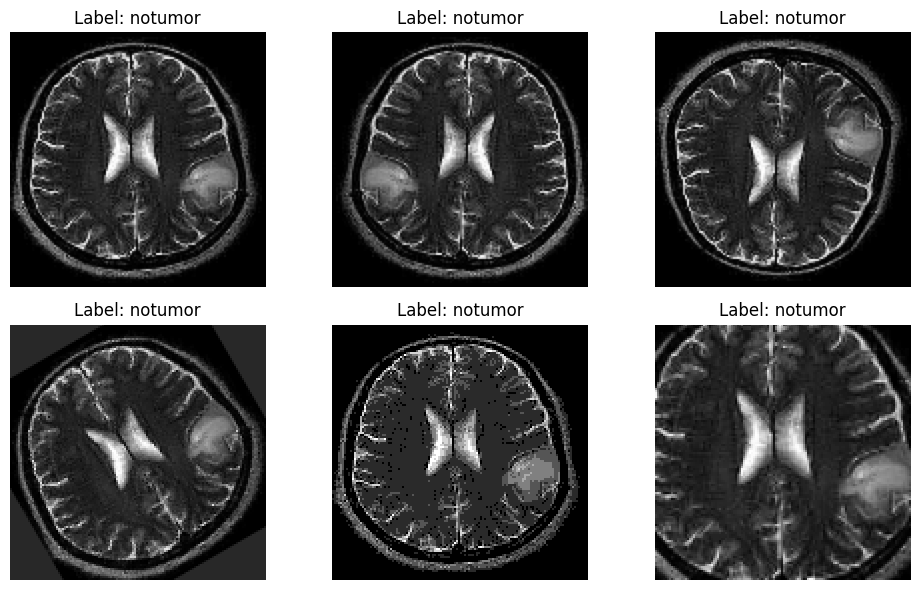

In [ ]:
X = np.array(X)
y = np.array(y)
print(f"Total augmented samples: {len(X)}")
# Display some augmented samples
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(X[i], cmap='gray')
    plt.title(f"Label: {y[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
